In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections
from glob import glob
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow


from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *

import astrohack
from astrohack import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x


import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.layers import Flatten, Conv2D, concatenate
from keras.optimizers import *




/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# TODO, improvement ideas

# TPOT python auto ml
# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)

# transformer le regresseur en classifier
# ensemble lgbm, xgboost, catboot, NN



#done
# lgbm eval rmsle instead of rmse
# add image size as feature
# CV2 resize cubic interpolation 



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)

mm
a= None

## data folder set up and test

In [4]:
astrohack.dataFolder = 'data/mainData_original/'
dataFolder = 'data/mainData_original/'
plt.ion()

runNameParams = []
runNameParams.append('retrain')
# print(runNameParams)

In [5]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

# ML part

In [6]:
# load all images in memory (or try to)

preprocList = [PP_HACKATON, PP_LOG100P, PP_CROP, PP_NORMALIZE, PP_SCALE01, PP_RESCALE299] 

df = pd.read_csv('fullPlusFeatures.csv')

In [7]:
df.shape

(77531, 50)

In [8]:
preprocessedImages = np.load('data/allimagespreprocessed' + str(preprocList) + '.npy')

# preprocessedImages = []
# for sdssid in tqdm(df.SDSS_ID.values):
#     preprocessedImages.append(img_preproclist(sdssid, preprocList))

# len(preprocessedImages)

# xx = np.stack(preprocessedImages)


# np.save('allimagespreprocessed' + str(preprocList) + '.npy', xx)

# preprocessedImages = xx

(77531, 299, 299)

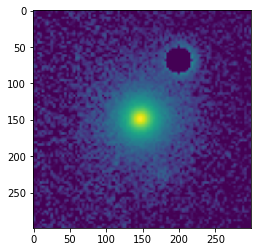

In [9]:
plt.imshow(preprocessedImages[random.randint(0,preprocessedImages.shape[0])])
preprocessedImages.shape

In [10]:
def lgb_chi2(Yp, train_data):
    Y = train_data.get_label()
    err = 1/train_data.get_weight()**0.5
    return 'Chi²', round(xi2(Y,Yp,err),1), False


In [11]:
TRAIN = 0
TEST = 4

FEATURES = 0
TRUTH = 1
ERROR = 2
LINERROR = 3

ID = 8
FEATURENAMES = 9

data = list(range(10))

In [12]:
data[TRAIN+FEATURES]

0

In [13]:
# breakqsdqsd

# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [14]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)

prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

prefixThisRound = prefixThisRound + '-model15'
    
chunkSize = 200
# nSplits = 3
reloadImagesAndPreprocess = 0
numPreprocessing = 1
nSplits = 1

# starting with hackaton is faster
preprocList = [PP_HACKATON, PP_LOG100P, PP_CROP, PP_NORMALIZE, PP_SCALE01, PP_RESCALE299] 
# preprocList = [PP_NORMALIZE, PP_LOG100P, PP_HACKATON, PP_SCALE255, PP_RESCALE224]
# preprocList = [PP_NORMALIZE, PP_LOG100P, PP_CROP, PP_SCALE255, PP_HACKATON, PP_RESCALE224]

maxBoostRuns = 30000 # 30000
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout
# N = int(N*0.1)
# M = int(M*0.1)


# N = int(N*0.01)
# M = int(M*0.01)


# import keras


In [15]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    epochsPerDraw = 10
    referencePrediction = None
    
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.test_losses = [] # external validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        self.lasttrainplot = None
        self.lasttestplot = None
        
    def on_train_begin(self, logs={}):
        self.initVars()
        self.referenceLoss = xi2(self.referencePrediction, data[TEST+TRUTH], data[TEST+ERROR])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        currentLearningRate = K.get_value(model.optimizer.lr)
        self.lr.append(currentLearningRate)

        if ( self.i %self.epochsPerDraw != 0 ):
            return

        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.suptitle("{}/{} {} {}".format(self.i, numEpochs, curloss, prefixThisRound))
        
#         ax = plt.subplot(131) # self values
#         if self.lasttrainplot == None or self.i %self.epochsPerDraw == 0:
#             self.plotSelfTrain(ax)
#         else:
#             ax = self.lasttrainplot

        ax = plt.subplot(121)
        if self.lasttestplot == None or self.i %self.epochsPerDraw == 0:
            self.plotSelfTest(ax)
        else:
            ax = self.lasttestplot
    
        ax = plt.subplot(122)
        self.plotLosses(ax)
        

        plt.savefig("pltsave/" + prefixThisRound + "%05d.png" % self.i)
        plt.show();
    
    def plotSelfTrain(self, ax):

        pred = model.predict(data[TRAIN+FEATURES])[:,0]
#         r = rmse(pred,data[TRAIN+TRUTH])
        r = xi2(pred,data[TRAIN+TRUTH], data[TRAIN+ERROR])
        plt.scatter(x=data[TRAIN+TRUTH], y=pred, c='k', alpha=.1, label="NN train {:.2f}".format(r))
#         sns.kdeplot(data[TRAIN+TRUTH], pred,n_levels=10, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
#         plt.plot([7, 13], [0,0], 'k-', lw=2, label="target")
#         axes = plt.gca()
#         axes.set_xlim([7,13])
        plt.legend()
        self.lasttrainplot = ax
    
    def plotSelfTest(self, ax):
        
        # lgbm values
        plt.scatter(x=data[TEST+TRUTH], 
                    y=self.referencePrediction, 
                    c='b', alpha=.1, label="ref {:02f}".format(self.referenceLoss))
        
        # test values
        pred = model.predict(data[TEST+FEATURES])[:,0]
        r = xi2(pred,data[TEST+TRUTH], data[TEST+ERROR])
        plt.scatter(x=data[TEST+TRUTH], y=pred, c='g', alpha=.1, label="NN test {:.2f}".format(r))
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
        plt.plot([0, 12], [0, 12], 'k-', lw=2, label="target")
#         axes = plt.gca()
#         axes.set_xlim([7,13])
        plt.legend()
        self.lasttestplot = ax

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        ax.set_yscale("log", nonposy='clip')
        ax.axhline(self.referenceLoss,linestyle='--')
        plt.legend()
        ax2 = ax.twinx()
        ax2.set_yscale('log')
        plt.plot(self.x,self.lr, c='r', label='learning rate', alpha=0.8)
        
#         plt.plot(self.x, self.testrmse, label="test rmse", c='g')
        plt.legend()

        
plot_losses = PlotLosses()

In [16]:
currentLearningRate = K.get_value(model.optimizer.lr)
print(currentLearningRate)
# K.set_value(model.optimizer.lr, 0.002)

NameError: name 'model' is not defined

In [ ]:
testIDX

In [ ]:
extraFeatures[i].shape

In [ ]:
i= 75223


In [ ]:
azeazeaze
# run the next one for same with cross validation

# Retrain inceptionResetnet

In [17]:
postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']
distanceNames = ['D', '1/D', 'D**2', '1/D**2']


In [18]:
featureNames = distanceNames + preImgFeatureNames + postImgFeatureNames

In [19]:
# #xx = np.concatenate([data[TRAIN+FEATURES],data[TEST+FEATURES]])
# # dfids = [df.index[df.SDSS_ID==x] for x in data[ID]]

# for i in range(len(featureNames)):
#     fn = 'f' + featureNames[i]
#     df.loc[dfids, fn] = xx[dfids,i]

# # print(df.shape)
# # np.concatenate([data[TRAIN+FEATURES][:,1],data[TEST+FEATURES][:,1]]).shape
# df.to_csv('fullPlusFeatures.csv')

In [26]:
from keras.layers import concatenate, Concatenate, MaxPooling2D

In [27]:
from keras import Model

In [28]:
# base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_shape=(299,299,3)) #, pooling='avg')


In [46]:
# x = base_model.output
inp = keras.layers.Input(shape=(299,299,1))
x = inp

extraFeaturesInput = keras.layers.Input(shape=(len(featureNames),))

x = Conv2D(32, (5,5), activation = 'relu', padding='same')(x)
x = MaxPooling2D((3,3))(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)

x = Conv2D(64, (5,5), activation = 'relu', padding='same')(x)
x = MaxPooling2D((3,3))(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)

x = Conv2D(128, (5,5), activation = 'relu', padding='same')(x)
x = MaxPooling2D((3,3))(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)

x = Flatten()(x)

x = Dense(256, activation = 'relu', kernel_initializer='truncated_normal',)(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)

x = concatenate([x, extraFeaturesInput])

# x = Dense(512, activation='relu',kernel_initializer='truncated_normal',)(x)
# x = BatchNormalization()(x)
# x = Dropout(0.9)(x)
# x = Dense(256, activation='relu',kernel_initializer='truncated_normal',)(x)
# x = BatchNormalization()(x)
# x = Dropout(0.9)(x)
x = Dense(128, activation='relu',kernel_initializer='truncated_normal',)(x)
x = BatchNormalization()(x)
x = Dropout(0.9)(x)
mymodel_output = Dense(1, activation='relu',kernel_initializer='truncated_normal')(x)

# i = 0
# for layer in base_model.layers:
#     i = i +1
#     if i < 500:
#         layer.trainable = False

model = Model([inp,extraFeaturesInput],mymodel_output)

model.compile(optimizer='nadam', loss='mse')

print(model.input,model.output.shape)

[<tf.Tensor 'input_15:0' shape=(?, 299, 299, 1) dtype=float32>, <tf.Tensor 'input_16:0' shape=(?, 19) dtype=float32>] (?, 1)


In [47]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 299, 299, 1)  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 299, 299, 32) 832         input_15[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 99, 99, 32)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 99, 99, 32)   128         max_pooling2d_13[0][0]           
__________________________________________________________________________________________________
dropout_36

In [31]:
# i = 0
# for layer in base_model.layers:
#     print(i, layer)
#     i = i +1

In [32]:
reduceLRcallback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1000, verbose=0, mode='auto', epsilon=0.0001, cooldown=20, min_lr=0)

In [33]:
preprocessedImages.shape

(77531, 299, 299)

In [34]:
print(M,N)

69777 77531


In [41]:
# dfidx = df.index.values
dfidx = df[(df.reduced_chi_square < 5)].index.values
trainIDX = dfidx[:M]
testIDX = dfidx[M:N]

Y = df.ML.values
err = df.ML_error.values
err = np.maximum(err, Y*0.05)
weights = 1/err**2

extraFeatures = df[['f' + x for x in featureNames]].values
losses = []

In [48]:
losses = []

[40.468273, 37.95224, 30.35902, 42.327217, 42.496418]
15000/2000000


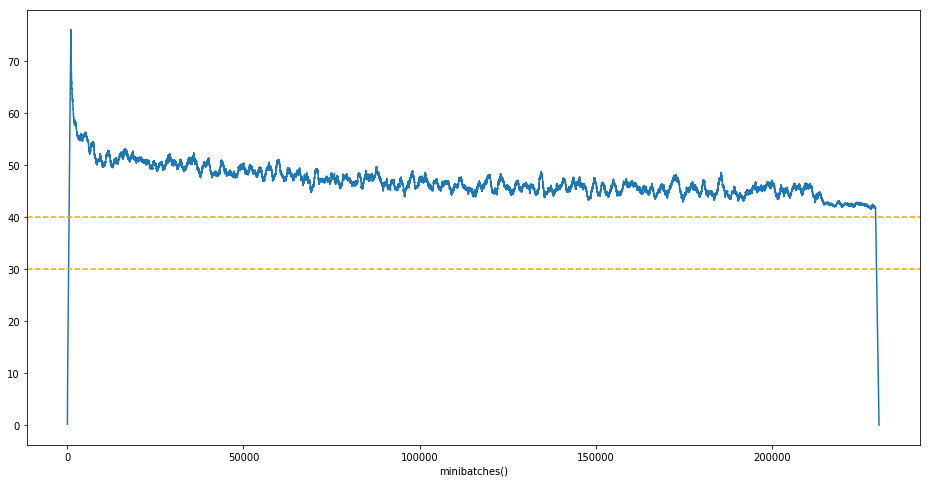

KeyboardInterrupt: 

In [54]:
startbatch = 0
minibatchsize = 150
numEpochs=2000000 # 1000 is One epoch

x = np.zeros((minibatchsize,299,299,1))
for epoch in range(numEpochs):
    indices = random.sample(set(trainIDX),minibatchsize)
    ii = preprocessedImages[indices]
    rr = random.randint(0,3)
    if rr == 0:
        ii = np.flip(ii,axis=1)
    elif rr == 1:
        ii = np.flip(ii,axis=2)
    else:
        x[:,:,:,:] = ii[:,:,:,newaxis]
    
    l = model.train_on_batch([x, extraFeatures[indices]], Y[indices], sample_weight=weights[indices])
    losses.append(l)
    if epoch % 1000 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.plot(np.convolve(losses, np.ones(1000))/1000)
        plt.axhline(40, c='orange', linestyle='--')
        plt.axhline(30, c='orange', linestyle='--')
        print(losses[-5:])
        print(f'{epoch}/{numEpochs}')
        plt.xlabel('minibatches()')
        plt.show()
# y = df.

In [55]:
model.save_weights('custom1.weights')

In [ ]:
# indices = random.sample(set(trainIDX),minibatchsize)
plt.imshow((preprocessedImages[indices])[1])
plt.figure()
plt.imshow(np.flip(preprocessedImages[indices], axis=2)[1])
plt.figure()
plt.imshow(np.flip(preprocessedImages[indices], axis=1)[1])


In [ ]:
!nvidia-smi

In [ ]:
pred = []
for i in tqdm(testIDX):
    x = np.zeros([1,299,299,3])
    x[:,:,:,:] = preprocessedImages[i][newaxis,:,:,newaxis]
    pred.append(model.predict([x, extraFeatures[i][newaxis,:]])[:,0][0])# print(x)

In [ ]:
linChiSq = xi2(Y[testIDX],pred,err[testIDX])
print(linChiSq)

g = plt.scatter(x=pred, y=Y[testIDX], alpha=.3)
g.x = x
g.y = Y[testIDX]
# g.plot_joint(plt.scatter, alpha=.3, c='r')
plt.suptitle('dataSize:{} epochs:{}'.format(epoch,numEpochs))

plt.legend(['lgbm', 'keras-rmsprop'])
# sns.jointplot(x=x[:,0], y=cvpred)

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title('lgbm, error(logM) distribution')
plt.scatter(x=pred, y=pred-Y[testIDX], alpha=0.1, c='k')
sns.kdeplot(pred, pred-Y[testIDX],n_levels=30, shade=True, shade_lowest=False, cmap='rainbow', alpha=0.7)
plt.plot([7,13],[0,0], 'k-')

In [ ]:
linChiSq = xi2(Y[testIDX],pred,err[testIDX])
print(linChiSq)

plt.figure(figsize=(16,16))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60,shade_lowest=False, )
sns.kdeplot(Y[testIDX], pred, alpha=0.99, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, bw=0.2, cut=0, n_levels=20, alpha=0.5)
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()

In [ ]:
plt.figure(figsize=(12,12))
# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

plt.title(prefixThisRound)
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60,shade_lowest=False, )
sns.kdeplot(cvpred, data[TEST+TRUTH], alpha=0.99, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=cvpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
# sns.kdeplot(cvpred, data[TEST+TRUTH], cmap=cmap, bw=0.2, cut=0, n_levels=20, alpha=0.5)
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()

In [ ]:
model.save_weights('partialretraininginceptionresnet-3.weights')

In [ ]:
base_model.save_weights('inceptiontuned.weights')

In [ ]:
plt.plot(np.convolve(losses, np.ones(1000))/1000)
plt.axhline(40, c='orange', linestyle='--')
plt.axhline(30, c='orange', linestyle='--')


In [ ]:
model.train_on_batch(x, Y[startbatch:startbatch+minibatchsize])

In [ ]:
# x = preprocessedImages[:20]
model.fit(x, 
#               sample_weight=1/(data[TRAIN+ERROR][:num])**2,
#               sample_weight=1/np.maximum(data[TRAIN+ERROR], data[TRAIN+TRUTH] * 0.05)**2,
          batch_size=1000, 
          epochs=numEpochs, 
          validation_split = 0.1, 
          verbose = 1,
          callbacks=[plot_losses,reduceLRcallback])

In [ ]:
nSplits = 10
models, cvtrainpreds = getLGBMModelsWithCV(data[TRAIN+FEATURES], data[TRAIN+TRUTH], data[TRAIN+ERROR])

ppreds = np.zeros([len(models),data[TEST+FEATURES].shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(data[TEST+FEATURES])
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)

In [ ]:
for i in range(len(ppreds)):
    linChiSq = xi2(ppreds[i], data[TEST+TRUTH], data[TEST+ERROR])
    print("Iteration {}: {}".format(i, linChiSq))

mpred = ppreds.reshape((10,-1)).mean(axis=0)

# cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=2.8, rot=.1, reverse=True)

linChiSq = xi2(mpred, data[TEST+TRUTH], data[TEST+ERROR])

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0.25,5], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('truth')

plt.legend()
plt.show()

plt.figure(figsize=(12,12))
plt.title(prefixThisRound)
sns.kdeplot(mpred, mpred-data[TEST+TRUTH], alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0, n_levels=60, label='LGB chi² {:.2f}'.format(linChiSq) )
plt.scatter(x=mpred, y=mpred-data[TEST+TRUTH], alpha=0.03, c='w', marker='x', label='LGB chi² {:.2f}'.format(linChiSq) )
plt.plot([0.25,5],[0,0], c='w', label='target')
plt.xlabel('prediction')
plt.ylabel('prediction error')

plt.legend()
plt.show()